In [14]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr


In [15]:
#Setup the system:

#For now, use same channel params
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[25,26], [2,2], [26,24], [48,2], [24, 24], [24,49]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


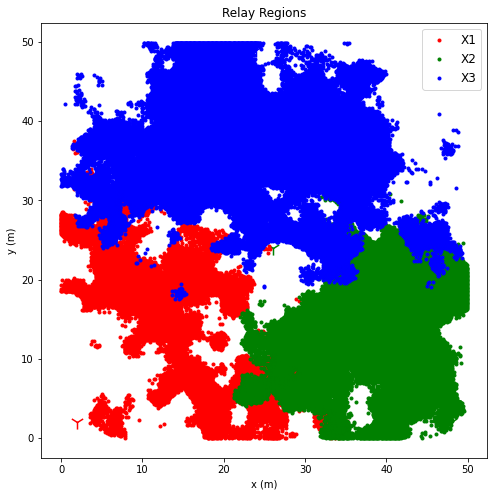

In [16]:
def indices_to_pts(r, region, res):
    #First get the non-zero indices
    idcs = np.array(np.where(r>0)).T
    pts = idcs - [region[1], region[3]]
    pts = pts/res
    return pts

fig = plt.figure(figsize=(8,8))
color_array=['r', 'g', 'b']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
for i in range(3):
    r = cfs[2*i]*cfs[2*i+1]
    pts = indices_to_pts(r, region, res)
    plt.plot(pts[:,0], pts[:,1], '.'+str(color_array[i]), label='X'+str(i+1))
    
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=color_array[i], marker='1', s=200)
    

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Relay Regions')
plt.legend(prop={'size':12})
plt.show()

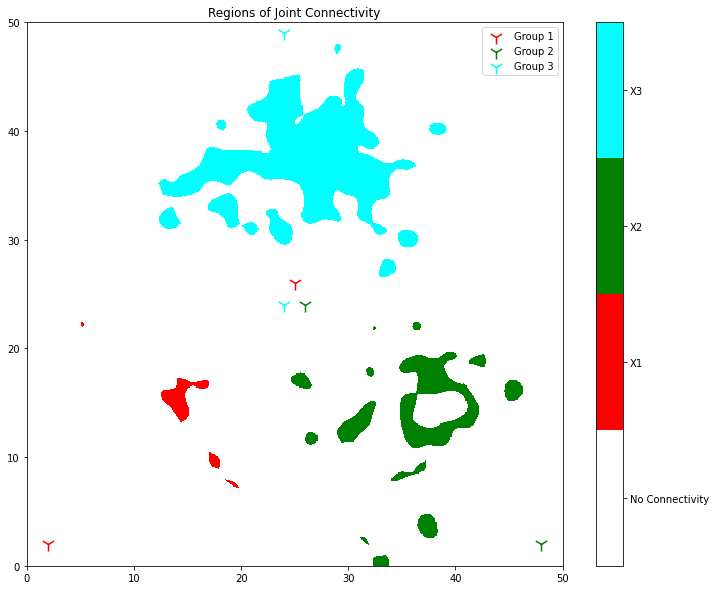

In [4]:
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [5]:
def indices_to_pts(r, region, res):
    #First get the non-zero indices
    idcs = np.where(r>0)
    pts = np.array(idcs).T - [region[1], region[3]]
    pts = pts/res
    return pts, np.array(idcs).T

pts1, idcs1 = indices_to_pts(r1, region, res)
pts2, idcs2 = indices_to_pts(r2, region, res)
pts3, idcs3 = indices_to_pts(r3, region, res)

all_pts, _ = indices_to_pts(np.ones(r1.shape), region, res)

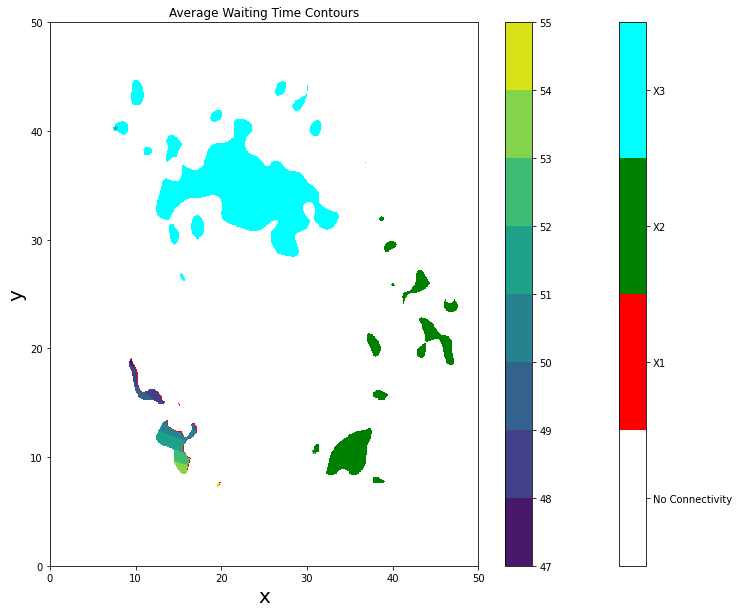

In [6]:
def XtoS(X, v = 1):
    n = len(X)
    S = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            dist = np.linalg.norm(X[i] - X[j])
            S[i,j] = dist
            S[j,i] = dist
    return S
#Setup the polling system
#TODO - reaosnable beta value?
ps = PS.PollingSystem([0.005, 0.0075, .001], 0.000001)
rp = MRP.RandomRP([1/2, 1/4, 1/4])

pt2 = pts2[0]
pt3 = pts3[0]
Z = -1*np.Inf*np.ones(r1.shape)
for i in range(len(pts1)):
    pt1 = pts1[i]
    S = XtoS([pt1, pt2, pt3])
    Z[idcs1[i,0], idcs1[i,1]] = ps.calc_avg_wait(rp, S)
    
#fig = plt.figure(figsize=(10,8))

color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)


cont = plt.contourf(np.arange(x_min, x_max, 1/res), np.arange(y_min, y_max, 1/res), Z.T)
fig = plt.gcf()
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(pt2[0], pt2[1], marker='*', s=25, c='g')
plt.scatter(pt3[0], pt3[1], marker='*', s=25, c='c')
plt.show()
    

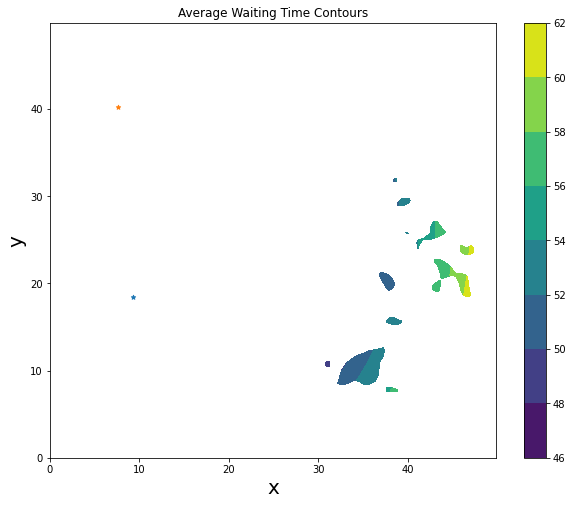

In [7]:
pt1 = pts1[0]
pt3 = pts3[0]
Z = -1*np.Inf*np.ones(r1.shape)
for i in range(len(pts2)):
    pt2 = pts2[i]
    S = XtoS([pt1, pt2, pt3])
    Z[idcs2[i,0], idcs2[i,1]] = ps.calc_avg_wait(rp, S)
    
fig = plt.figure(figsize=(10,8))
cont = plt.contourf(np.arange(x_min, x_max, 1/res), np.arange(y_min, y_max, 1/res), Z.T)
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(pt1[0], pt1[1], marker='*', s=20)
plt.scatter(pt3[0], pt3[1], marker='*', s=20)
plt.show()

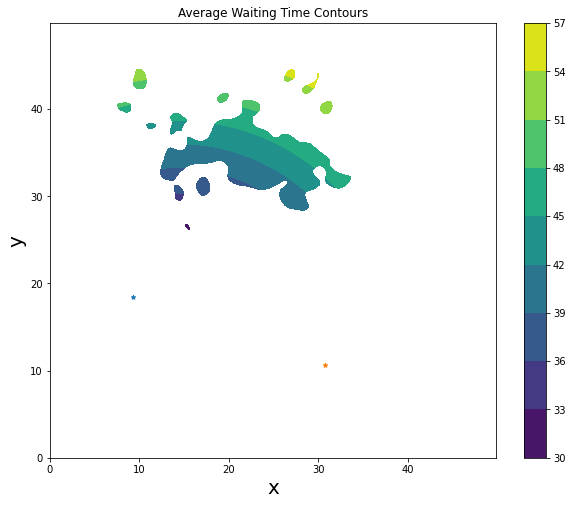

In [8]:
pt1 = pts1[0]
pt2 = pts2[0]
Z = -1*np.Inf*np.ones(r1.shape)
for i in range(len(pts3)):
    pt3 = pts3[i]
    S = XtoS([pt1, pt2, pt3])
    Z[idcs3[i,0], idcs3[i,1]] = ps.calc_avg_wait(rp, S)
    
fig = plt.figure(figsize=(10,8))
cont = plt.contourf(np.arange(x_min, x_max, 1/res), np.arange(y_min, y_max, 1/res), Z.T)
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(pt1[0], pt1[1], marker='*', s=20)
plt.scatter(pt2[0], pt2[1], marker='*', s=20)
plt.show()
    

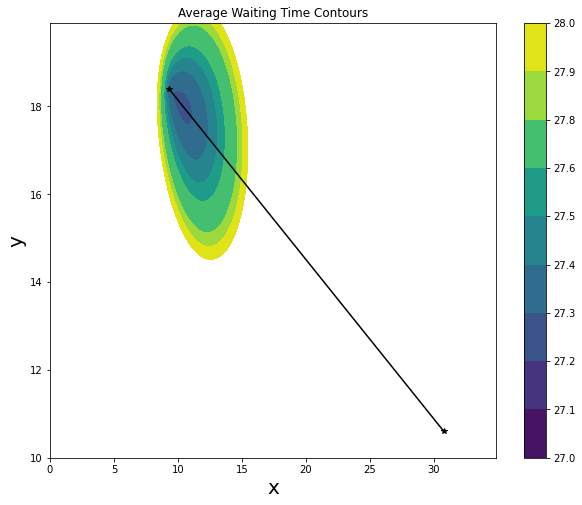

In [28]:
#Just for fun, let's see what this would look like without any boundaries
pt1 = pts1[0]
pt2 = pts2[0]
all_x = np.arange(0, 35, 1/res)
all_y = np.arange(10, 20, 1/res)
Z = np.ones((len(all_x), len(all_y)))
for i in range(len(all_x)):
    for j in range(len(all_y)):
        pt3 = [all_x[i], all_y[j]]
        S = XtoS([pt1, pt2, pt3])
        Z[i, j] = ps.calc_avg_wait(rp, S)
    
fig = plt.figure(figsize=(10,8))
cont = plt.contourf(all_x, all_y, Z.T, [27,27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28])
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]] ,'k*-')
# plt.scatter(pt1[0], pt1[1], marker='*', s=20, color='k')
# plt.scatter(pt2[0], pt2[1], marker='*', s=20, color='k')
plt.show()

In [ ]:
#from above, we see that reducing/minimizing average switching time does not always reduce average waiting time

In [7]:
import pointcloud as PC
from importlib import reload 
reload(dtr)
reload(MRP)
reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Constructed 13 possibly non-convex polygons
55 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 10 possibly non-convex polygons
80 total subregions
Optimized Policy Waiting Time: 63.0499
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 762 rows, 157 columns and 2324 nonzeros
Model fingerprint: 0xe7d6d8c8
Model has 3 quadratic constraints
Variable types: 9 continuous, 148 integer (148 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [9e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

*  245   175              57       3.2572990    0.24983  92.3%   6.8    1s
H  510   257                       3.2572990    0.41330  87.3%   6.5    2s
   534   273    1.07047   15    8    3.25730    1.07047  67.1%   6.2    5s
* 1029   263              68       3.2572990    1.23811  62.0%   5.5    7s
* 1031   250              69       3.2572990    1.23811  62.0%   5.5    7s
* 1033   236              70       3.2572990    1.23811  62.0%   5.5    7s
* 1035   223              71       3.2572990    1.23811  62.0%   5.5    7s
* 1037   212              72       3.2572990    1.23811  62.0%   5.5    7s
* 1039   200              73       3.2572990    1.23811  62.0%   5.4    7s
* 1041   189              74       3.2572990    1.23811  62.0%   5.4    7s
* 1043   179              75       3.2572990    1.23811  62.0%   5.4    7s
* 1045   170              76       3.2572990    1.23811  62.0%   5.4    7s
* 1046   169              76       3.2572990    1.23811  62.0%   5.4    7s
  1966   259     cutoff  

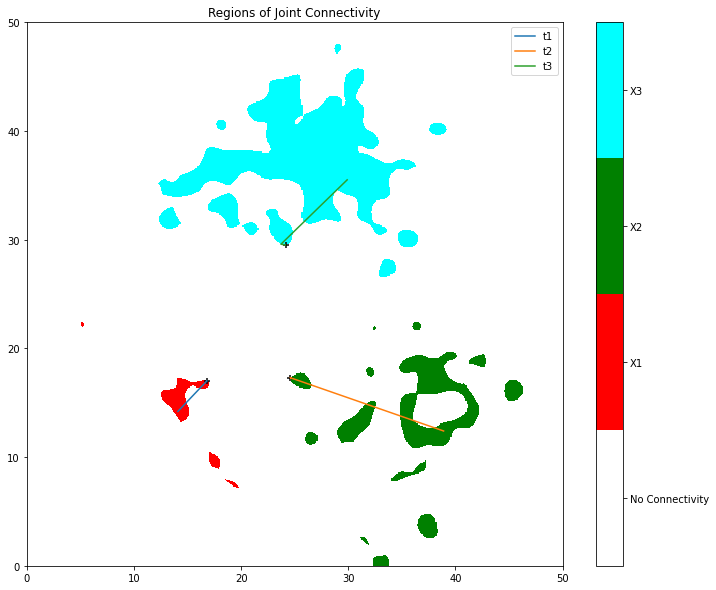

Optimized Waiting Time: 27.4306


(array([0.287515  , 0.51202139, 0.20046361]),
 array([[16.8       , 17.        ],
        [24.6       , 17.3       ],
        [24.14463707, 29.50922715]]))

In [8]:
els = [0.5, 0.7, 0.5]
beta = 0.2
sys = dtr.DTR(ccs, els, beta)
sys.optimize(x_opt_method=3)

Optimized Policy Waiting Time: 47.0717
Optimized Location Waiting Time: 44.8272
Optimized Policy Waiting Time: 44.2081
Optimized Location Waiting Time: 43.1632
Optimized Policy Waiting Time: 43.4516
Optimized Location Waiting Time: 41.2316
Optimized Policy Waiting Time: 41.9895
Optimized Location Waiting Time: 41.2613
Optimized Policy Waiting Time: 41.0528
Optimized Location Waiting Time: 40.7831
Optimized Policy Waiting Time: 41.0108
Optimized Location Waiting Time: 40.8624
Optimized Policy Waiting Time: 41.0948
Optimized Location Waiting Time: 40.8089
Optimized Policy Waiting Time: 41.0374
Optimized Location Waiting Time: 41.1748
Optimized Policy Waiting Time: 40.8609
Optimized Location Waiting Time: 40.7789
Optimized Policy Waiting Time: 40.6799
Optimized Location Waiting Time: 40.8443


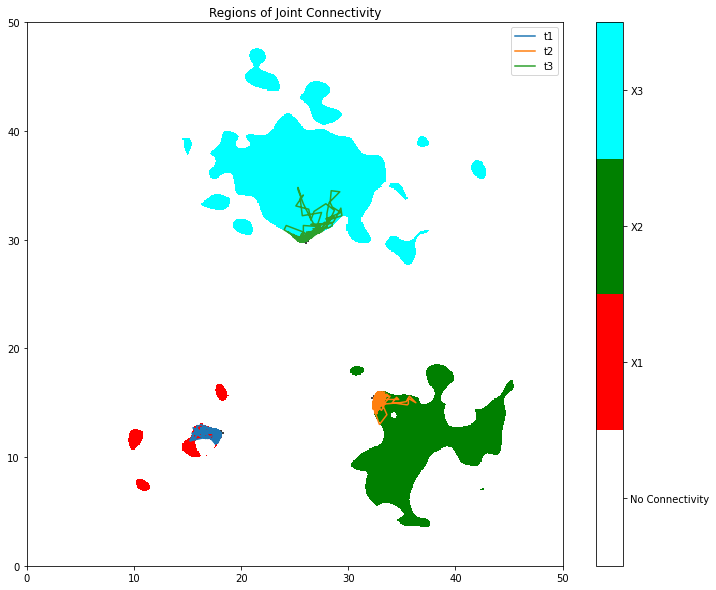

Optimized Waiting Time: 40.6696


(array([0.27066998, 0.4677942 , 0.26153582]),
 array([[18.1, 12.2],
        [32.4, 15.4],
        [26. , 29.9]]))

In [77]:
els = [0.5, 0.7, 0.5]
beta = 0.2
sys = dtr.DTR(ccs, els, beta)
sys.optimize(x_opt_method = 2)

In [46]:
for reg in sys.cregions:
    for poly in reg.polygons:
        for cnvx in poly.cnvx_partition:
            print(cnvx.to_linear_constraints())

Poly.Edge: [[19.6  7.3]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.5]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.3]
 [19.6  7.5]]
(array([[-3.,  1.],
       [-1.,  1.],
       [-1.,  0.]]), array([[ 51.5],
       [ 12.1],
       [-19.6]]))
Poly.Edge: [[12.2 15.3]
 [12.5 16. ]]
Poly.Edge: [[12.2 15.3]
 [12.3 15.2]]
Poly.Edge: [[12.3 15.2]
 [12.8 14.9]]
Poly.Edge: [[12.8 14.9]
 [13.3 15. ]]
Poly.Edge: [[12.5 16. ]
 [13.3 15. ]]
(array([[-2.33333333,  1.        ],
       [-1.        , -1.        ],
       [-0.6       , -1.        ],
       [ 0.2       , -1.        ],
       [-1.25      , -1.        ]]), array([[13.16666667],
       [27.5       ],
       [22.58      ],
       [12.34      ],
       [31.625     ]]))
Poly.Edge: [[ 9.3 18.4]
 [ 9.7 17.7]]
Poly.Edge: [[ 9.7 17.7]
 [10.  18. ]]
Poly.Edge: [[ 9.4 19. ]
 [10.  18. ]]
Poly.Edge: [[ 9.3 18.4]
 [ 9.4 19. ]]
(array([[-1.75      , -1.        ],
       [ 1.        , -1.        ],
       [-1.66666667, -1.        ],
       [-6.        ,  1.        ]]), a

 [29.4 32.6]]
Poly.Edge: [[26.5 31.8]
 [26.6 31.5]]
Poly.Edge: [[26.6 31.5]
 [28.6 30.5]]
Poly.Edge: [[28.6 30.5]
 [29.8 31. ]]
Poly.Edge: [[29.8 31. ]
 [30.2 31.7]]
Poly.Edge: [[29.4 32.6]
 [30.2 31.7]]
(array([[ 0.27586207, -1.        ],
       [-3.        , -1.        ],
       [-0.5       , -1.        ],
       [ 0.41666667, -1.        ],
       [-1.75      ,  1.        ],
       [-1.125     , -1.        ]]), array([[ 24.48965517],
       [111.3       ],
       [ 44.8       ],
       [ 18.58333333],
       [ 21.15      ],
       [ 65.675     ]]))
Poly.Edge: [[30.8 33.1]
 [31.3 33.4]]
Poly.Edge: [[30.8 33.1]
 [31.8 32.9]]
Poly.Edge: [[31.3 33.4]
 [31.8 32.9]]
(array([[ 0.6, -1. ],
       [-0.2, -1. ],
       [-1. , -1. ]]), array([[14.62],
       [39.26],
       [64.7 ]]))
Poly.Edge: [[17.6 33.8]
 [18.6 34.1]]
Poly.Edge: [[17.1 36.3]
 [18.6 34.1]]
Poly.Edge: [[16.6 36.3]
 [17.1 36.3]]
Poly.Edge: [[15.4 35.9]
 [16.6 36.3]]
Poly.Edge: [[15.1 35.4]
 [15.4 35.9]]
Poly.Edge: [[15.1 35.4]

In [61]:
constraint_blocks = []
b_final = np.zeros((0,1))
for reg in sys.cregions:
    n_constraints = 0
    As = np.zeros((0,2))
    bs = []
    Cs = []
       
    n_vars = 2
    for poly in reg.polygons:
        for cnvx in poly.cnvx_partition:
                n_vars += 1
                Aik,bik = cnvx.to_linear_constraints()
                As = np.concatenate((As,Aik), axis = 0)
                bs += bik.tolist()
                C = -1*10000 #actually need to find a value of this constant
                Cs.append(np.ones(len(bik))*C)
             
    n_constraints = len(bs)
    A = np.zeros((n_constraints, n_vars))
    A[:,:2] = As
    idx = 0
    for i in range(n_vars - 2):
        C = Cs[i]
        lc = len(C)
        A[idx:idx+lc, 2+i] = C
        idx += lc
    b = np.array(bs)
    
    b_final = np.concatenate((b_final, b))
    constraint_blocks.append(A)
    print('Completed Region')
    

Poly.Edge: [[19.6  7.3]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.5]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.3]
 [19.6  7.5]]
Poly.Edge: [[12.2 15.3]
 [12.5 16. ]]
Poly.Edge: [[12.2 15.3]
 [12.3 15.2]]
Poly.Edge: [[12.3 15.2]
 [12.8 14.9]]
Poly.Edge: [[12.8 14.9]
 [13.3 15. ]]
Poly.Edge: [[12.5 16. ]
 [13.3 15. ]]
Poly.Edge: [[ 9.3 18.4]
 [ 9.7 17.7]]
Poly.Edge: [[ 9.7 17.7]
 [10.  18. ]]
Poly.Edge: [[ 9.4 19. ]
 [10.  18. ]]
Poly.Edge: [[ 9.3 18.4]
 [ 9.4 19. ]]
Poly.Edge: [[11.1 15.9]
 [11.7 16.2]]
Poly.Edge: [[11.1 15.9]
 [12.2 15.3]]
Poly.Edge: [[12.2 15.3]
 [12.5 16. ]]
Poly.Edge: [[11.7 16.2]
 [12.5 16. ]]
Poly.Edge: [[11.  15.3]
 [12.2 15.3]]
Poly.Edge: [[11.1 15.9]
 [12.2 15.3]]
Poly.Edge: [[10.7 15.9]
 [11.1 15.9]]
Poly.Edge: [[10.7 15.9]
 [11.  15.3]]
Poly.Edge: [[ 9.9 16.5]
 [10.3 15.7]]
Poly.Edge: [[10.3 15.7]
 [10.4 16.2]]
Poly.Edge: [[10.1 16.9]
 [10.4 16.2]]
Poly.Edge: [[ 9.7 17.7]
 [10.1 16.9]]
Poly.Edge: [[ 9.7 17.7]
 [ 9.9 16.5]]
Poly.Edge: [[10.3 15.7]
 [11.  15.3]]
Poly.Edge: [

In [62]:
constraint_blocks

[array([[-3.0e+00,  1.0e+00, -1.0e+04, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [-1.0e+00,  1.0e+00, -1.0e+04, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [-1.0e+00,  0.0e+00, -1.0e+04, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        ...,
        [-1.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00, -1.0e+04],
        [-1.0e+00, -1.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00, -1.0e+04],
        [-2.5e-01, -1.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00, -1.0e+04]]),
 array([[-3.33333333e-01, -1.00000000e+00, -1.00000000e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.00000000e+00, -1.00000000e+00, -1.00000000e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00, -1.00000000e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.50000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+04],
        [ 3.333333

In [60]:
A[2+idx:2+idx+lc, 2+i]

array([0., 0., 0.])

In [63]:
import scipy.linalg as lin

In [64]:
A_final = lin.block_diag(*constraint_blocks)

In [65]:
A_final

array([[-3.e+00,  1.e+00, -1.e+04, ...,  0.e+00,  0.e+00,  0.e+00],
       [-1.e+00,  1.e+00, -1.e+04, ...,  0.e+00,  0.e+00,  0.e+00],
       [-1.e+00,  0.e+00, -1.e+04, ...,  0.e+00,  0.e+00,  0.e+00],
       ...,
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -1.e+04],
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -1.e+04],
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -1.e+04]])

In [66]:
A_final.shape

(593, 123)

In [67]:
b_final.shape

(593, 1)

In [68]:
#To use Gurobi, I need to make the objective either linear or quadratic

import gurobipy as gp
from gurobipy import GRB

In [186]:
m = gp.Model('min_pairwise_distance')
#setup dummy variables required for linear objective
n_regions = 3
n_edges = np.sum([i for i in range(n_regions)])
s = [m.addVar() for i in range(n_edges)]
m.setObjective(np.sum(s))
xs = [m.addVar() for i in range(n_regions)]
ys = [m.addVar() for i in range(n_regions)]

ij = 0
for i in range(n_regions):
    for j in range(i+1, n_regions): 
        #add the quadratic constraint that ||xi - xj||^2 = sij^2
        M = np.array([[1,0,0, 0, 0],[0,-1,1, 0, 0],[0,1,-1, 0, 0], [0, 0, 0, -1, 1], [0, 0, 0, 1, -1]])
        xc=[s[ij], xs[i], xs[j], ys[i], ys[j]]
        m.addMQConstr(M,None, GRB.EQUAL, 0, xc, xc)
        ij += 1


        
#set up eta constraints
eta = []
for i in range(n_regions):
    reg = sys.cregions[i]
    As = np.zeros((0,2))
    bs = []
    Cs = []
       
    n_vars = 2
    for poly in reg.polygons:
        for cnvx in poly.cnvx_partition:
                n_vars += 1
                Aik,bik = cnvx.to_linear_constraints()
                As = np.concatenate((As,Aik), axis = 0)
                C = 1*10000*np.ones(len(bik)) #actually need to find a value of this constant
                Cs.append(C)
                bs += (bik[:,0]+C).tolist()
    
    eta_i = [m.addVar(vtype=GRB.BINARY) for k in range(n_vars-2)]
    m.addConstr(np.sum(eta_i) == 1)
    eta.append(eta_i)
    n_constraints = len(bs)
    A = np.zeros((n_constraints, n_vars))
    A[:,:2] = As
    idx = 0
    for j in range(n_vars - 2):
        C = Cs[j]
        lc = len(C)
        A[idx:idx+lc, 2+j] = C
        idx += lc
    b = np.array(bs)
    
    LMC = m.addMConstr(A, [xs[i], ys[i] , *eta_i], GRB.LESS_EQUAL, b)
    
    print('Completed Region')

Completed Region
Completed Region
Completed Region


In [187]:
#and now solve (hopefully)
m.params.NonConvex = 2
m.optimize()

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 597 rows, 126 columns and 1796 nonzeros
Model fingerprint: 0x724dc06a
Model has 3 quadratic constraints
Variable types: 9 continuous, 117 integer (117 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 91 rows and 0 columns
Presolve time: 0.08s
Presolved: 560 rows, 141 columns, 3499 nonzeros
Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 117 integer (117 binary)

Root relaxation: objective 0.000000e+00, 44 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

In [188]:
s

[<gurobi.Var C0 (value 13.930183030195067)>,
 <gurobi.Var C1 (value 13.472935386400195)>,
 <gurobi.Var C2 (value 21.566872086069093)>]

In [189]:
xs

[<gurobi.Var C3 (value 17.000000000000114)>,
 <gurobi.Var C4 (value 30.79999999999928)>,
 <gurobi.Var C5 (value 15.600000559040993)>]

In [190]:
ys

[<gurobi.Var C6 (value 12.799999999999157)>,
 <gurobi.Var C7 (value 10.900000000000148)>,
 <gurobi.Var C8 (value 26.199999627306433)>]

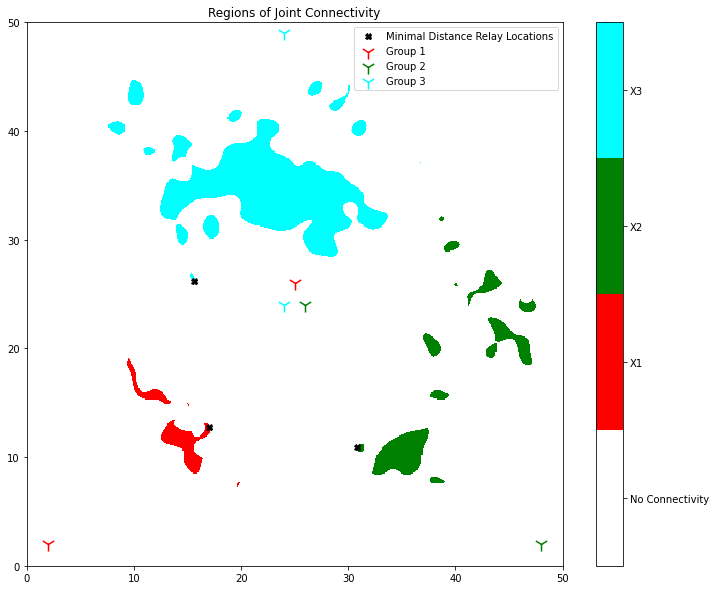

In [202]:
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)



px = [gv.x for gv in xs] 
py = [gv.x for gv in ys] 
plt.plot(px, py, 'kX', label='Minimal Distance Relay Locations')

plt.legend()    
plt.show()

In [207]:
m.getObjective().getValue()
m.status

2

<gurobi.Var C98 (value 1.0)>
(array([[ 5.        , -1.        ],
       [ 0.5       ,  1.        ],
       [-0.78947368, -1.        ]]), array([[112.5],
       [ 44.8],
       [-52.5]]))


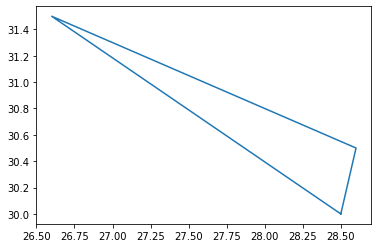

In [169]:
q = 0
for poly in reg.polygons:
        for cnvx in poly.cnvx_partition:
            if eta_i[q].x==1:
                print(eta_i[q])
                cnvx.plot()
                print(cnvx.to_linear_constraints())
            q += 1

In [173]:
LMC.slack

array([10042.46      , 10042.46      , 10042.46      , 10042.46      ,
       10042.46      , 10042.46      , 10042.46      , 10042.46      ,
        9991.56666667,  9991.56666667,  9991.56666667,  9991.56666667,
        9991.56666667,  9991.56666667,  9970.78      ,  9970.78      ,
        9970.78      ,  9970.78      ,  9970.78      ,  9970.78      ,
       10038.97142857, 10038.97142857, 10038.97142857, 10038.97142857,
        9973.3       ,  9973.3       ,  9973.3       ,  9973.3       ,
        9973.3       ,  9973.3       ,  9973.3       ,  9973.3       ,
       10056.42      , 10056.42      , 10056.42      , 10056.42      ,
       10056.42      , 10056.42      ,  9982.15      ,  9982.15      ,
        9982.15      ,  9982.15      , 10045.6       , 10045.6       ,
       10045.6       , 10045.6       , 10045.6       , 10045.6       ,
       10045.6       , 10042.1       , 10042.1       , 10042.1       ,
       10042.1       , 10042.1       , 10038.4       , 10038.4       ,
      

In [ ]:
gp.LogToConsole

In [178]:
b - LMC.slack

array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
      

In [179]:
(bik[0]+C)

array([9970.4, 9970.4, 9970.4])

In [185]:
bik[:,0]

array([-29.6       ,  36.33333333,  13.5       ])